In [170]:
## general
import numpy as np
import datetime
from sklearn.externals import joblib
import copy
import cf_units
import xarray as xr
import os
import sys
from tqdm import tqdm_notebook as tqdm
import datetime as dt
import matplotlib as mpl
import math

## statistics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats
from scipy.stats import multivariate_normal # to compute likelihood
from sklearn.impute import SimpleImputer
#from scipy.stats import shapiro  #check normalicy of seasonal trend distribution
from scipy.optimize import curve_fit, fmin, fminbound, minimize, rosen_der, least_squares
from sklearn.preprocessing import StandardScaler
import pickle

##import functions for fitting
from symfit import parameters, variables, Fit
from symfit import pi,sqrt,log,exp,sinh
from symfit import sin, cos


# statistics which aren't all that nice in python
import rpy2.robjects as robjects

## my stuff
sys.path.insert(1,'/home/tristan/mesmer/tools')
#from tools.loading import load_data_single_mod
from tools.processing import AR1_predict, compute_llh_cv,gaspari_cohn
from tools.plotting import TaylorDiagram


## plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy.ma as ma
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import mplotutils as mpu
import matplotlib.patches as mpatches
import seaborn as sns


##for parallelisation
from sklearn.externals.joblib import Parallel, delayed


In [171]:
dir_in_data = '/home/tristan/mesmer/data/'
file = 'GISS_tas_g25.nc'

df_GISS = xr.open_mfdataset(dir_in_data+file).roll(lon=72)

In [172]:
df_GISS['lon'] = df_GISS['lon'] - 180
df_GISS['temp'] = df_GISS['tempanomaly']
df_GISS = df_GISS.drop(['tempanomaly'])
df_GISS
#### create climatology array #################

<xarray.Dataset>
Dimensions:    (time: 1709, bnds: 2, lon: 144, lat: 72)
Coordinates:
  * time       (time) datetime64[ns] 1880-01-15 1880-02-15 ... 2022-05-15
  * lon        (lon) float64 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5
  * lat        (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(1709, 2), meta=np.ndarray>
    temp       (time, lat, lon) float32 dask.array<chunksize=(1709, 72, 144), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Sun Jul 03 16:18:14 2022: cdo remapcon2,r144x72 GISS_tas.nc...
    source:       http://data.giss.nasa.gov/gistemp/
    institution:  NASA Goddard Institute for Space Studies
    title:        GISTEMP Surface Temperature Analysis
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...

In [94]:
### calculate GISS climatology ###########s

clm = df_GISS.sel(time=slice('1951-01-01','1980-01-01')).groupby('time.month').mean(dim='time')
GISS_climatology = clm.temp.values
GISS_climatology.shape

(12, 72, 144)

<xarray.Dataset>
Dimensions:  (time: 1709, lon: 144, lat: 72)
Coordinates:
  * time     (time) float64 -2.839e+18 -2.836e+18 ... 1.65e+18 1.653e+18
  * lon      (lon) float64 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5
  * lat      (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
Data variables:
    temp     (time, lat, lon) float32 dask.array<chunksize=(1709, 72, 144), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Sun Jul 03 16:18:14 2022: cdo remapcon2,r144x72 GISS_tas.nc...
    source:       http://data.giss.nasa.gov/gistemp/
    institution:  NASA Goddard Institute for Space Studies
    title:        GISTEMP Surface Temperature Analysis
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...

In [44]:
# load the land mask as frac_l
dir_in_geo_dist = '/home/tristan/mesmer/data/'
frac_l = xr.open_mfdataset(dir_in_geo_dist + 'interim_invariant_lsmask_regrid.nc', combine='by_coords',decode_times=False)

frac_l_raw = np.squeeze(copy.deepcopy(frac_l.lsm.values))  #land-sea mask of ERA-interim bilinearily interpolated 

frac_l = frac_l.where(frac_l.lat>-60,0)  # remove Antarctica from frac_l field (ie set frac l to 0)

idx_l=np.squeeze(frac_l.lsm.values)>0.0 # idx_l = index land -> idex land #-> everything >0 we consider as land

lon_pc, lat_pc = mpu.infer_interval_breaks(frac_l.lon, frac_l.lat)  ## is this needed??

## Load in GISS dataset and use climatology values from BEST?

In [95]:
dir_in_data_mod = '/home/tristan/mesmer/data/'

# prepare the inputs as array
BEST_data = 'obs_data_25.nc'
data_mask = 'interim_invariant_lsmask_regrid.nc'       

df_BEST = xr.open_mfdataset(dir_in_geo_dist+BEST_data).roll(lon=72) #open observation data

#create the climatology values array
nr_years = 112
tot_months = 12*nr_years 

#create the climatology values array
y_ma = np.zeros((tot_months,idx_l.sum()))  #create emtpy array with correct shape
for i in range(tot_months):
    y_ma[i] = GISS_climatology[i%12,idx_l]    #fill climatology values in the array

#create test data over date range - here, 112 years so 1910 incl. to 2022. 
## 1344 is the number of months from 1910 until 2022
data_test = np.nan_to_num(np.array([df_GISS.temp.values[360:1704,idx_l]]))
data_test = data_test.reshape(tot_months,idx_l.sum())

print(data_test.shape)

###load in monthly temperature values by adding the temp anomolies to the climatology
y_all_mon = np.add(y_ma, data_test)     

# now subtract the yearly average climatology so we are left with residuals
y_all_mon = y_all_mon - np.reshape(np.tile(np.mean(df_BEST.climatology.values[:,idx_l],axis=0),tot_months),(tot_months,idx_l.sum()))   

# ################## UNTIL HERE #########################             

#calculate annual average temperature values- here we use nanmean to calculate the annual means for each gridpoint but skipping any Nan values
y_all = np.mean(y_all_mon.reshape(-1,12,idx_l.sum()),axis=1)
print(y_all.shape)

(1344, 3043)
(112, 3043)


## start plotting the data

In [97]:
### set plot params

params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'x-large',
          'figure.figsize': (9,5),
          "font.family": "serif",
         'ytick.labelsize':'x-large',
         "font.weight":"normal",
         "axes.labelweight":"normal"}
plt.rcParams.update(params)

In [ ]:
######## convert datetime64 to float for averaging #########

df_GISS['time'] = df_GISS['time'].values.astype(float)
df_GISS = df_GISS.drop(['time_bnds'])
df_GISS

In [113]:
def cos_wgt(ds, lat_string):
    
    from numpy import cos, deg2rad
    if lat_string == 'latitude':
        weights = np.cos(np.deg2rad(ds.latitude))
        
    else:
        weights = np.cos(np.deg2rad(ds.lat))
    
    return weights

wgt = cos_wgt(df_GISS, 'lat')
wgt

<xarray.DataArray 'lat' (lat: 72)>
array([0.02181489, 0.06540313, 0.10886687, 0.15212339, 0.19509032,
       0.23768589, 0.27982901, 0.32143947, 0.36243804, 0.40274669,
       0.44228869, 0.48098877, 0.51877326, 0.55557023, 0.59130965,
       0.62592347, 0.65934582, 0.69151306, 0.72236396, 0.75183981,
       0.77988448, 0.8064446 , 0.83146961, 0.85491187, 0.87672676,
       0.89687274, 0.91531148, 0.93200787, 0.94693013, 0.96004985,
       0.97134207, 0.98078528, 0.98836151, 0.99405634, 0.99785892,
       0.99976203, 0.99976203, 0.99785892, 0.99405634, 0.98836151,
       0.98078528, 0.97134207, 0.96004985, 0.94693013, 0.93200787,
       0.91531148, 0.89687274, 0.87672676, 0.85491187, 0.83146961,
       0.8064446 , 0.77988448, 0.75183981, 0.72236396, 0.69151306,
       0.65934582, 0.62592347, 0.59130965, 0.55557023, 0.51877326,
       0.48098877, 0.44228869, 0.40274669, 0.36243804, 0.32143947,
       0.27982901, 0.23768589, 0.19509032, 0.15212339, 0.10886687,
       0.06540313, 0.02181489])
Coordinates:
  * lat      (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
Attributes:
    standard_name:  latitude
    long_name:      latitude
    units:          degrees_north
    axis:           Y

In [169]:
df_weighted = df_GISS.weighted(wgt)
df_weighted_mean = df_weighted.mean(("lat", "lon"))
df_weighted_mean

AttributeError: 'Dataset' object has no attribute 'shape'

In [126]:
df_obs_np = np.array(df_weighted_mean['temp'])

print(df_obs_np.shape)

df_obs_smooth = df_weighted_mean.rolling(time=12*5, center=True).mean()
df_obs_smooth = np.array(df_obs_smooth['temp'])

print(df_obs_smooth.shape)

(1709,)
(1709,)


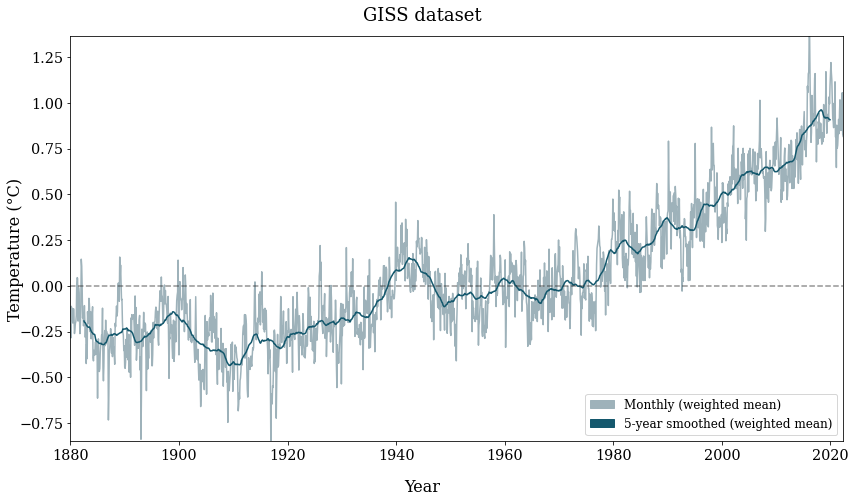

In [132]:
time = np.arange(np.datetime64('1880-01-01'), np.datetime64('2022-06-01'), dtype='datetime64[M]')
time2 = np.arange(np.datetime64('1880'), np.datetime64('2022'), dtype='datetime64[Y]')

fig, ax = plt.subplots(figsize=(12,7))
fig.suptitle("GISS dataset", fontsize=18)
fig.supylabel("Temperature (°C)", fontsize=16)
fig.supxlabel("Year", fontsize=16)

#create legend
monthly_vals = mpatches.Patch(color="#9EB2BA", label="Monthly (weighted mean)")
obs_yr_vals = mpatches.Patch(color="#14586D", label="5-year smoothed (weighted mean)")


ax.plot(time,
       df_obs_np,
        color="#9EB2BA")
ax.plot(time,
       df_obs_smooth,
        color="#14586D")

plt.axhline(y=0, color='#2a2a2a', linestyle='--', alpha=0.5)

ax.legend(handles=[monthly_vals, obs_yr_vals], loc="lower right", prop={'size': 12})


plt.tight_layout()
plt.margins(x=0, y=0)
plt.show()

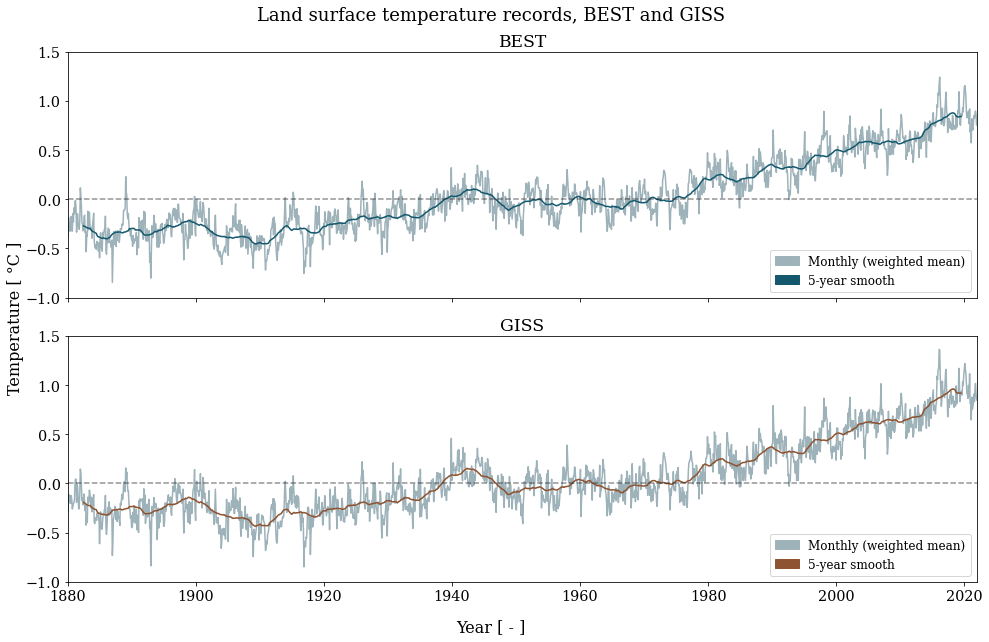

In [168]:
dir_in_data_mod = '/home/tristan/mesmer/data/'
    
#prepare the inputs as array
BEST_data = 'obs_data_25.nc'
GISS_data = 'GISS_tas_g25.nc'

# load in full Earth observation data
df_BEST = xr.open_mfdataset(dir_in_data_mod+BEST_data).roll(lat=72).sel(time=slice('1880-01-01','2022-01-01'))
df_GISS = xr.open_mfdataset(dir_in_data_mod+GISS_data).roll(lat=72).sel(time=slice('1880-01-01','2022-01-01'))

wgt_BEST = cos_wgt(df_BEST, 'lat')
wgt_GISS = cos_wgt(df_GISS, 'lat')

df_BEST_weighted = df_BEST.weighted(wgt_BEST)

df_GISS['temp'] = df_GISS['tempanomaly']
df_GISS = df_GISS.drop(['tempanomaly'])
df_GISS['time'] = df_GISS['time'].values.astype(float)
df_GISS = df_GISS.drop(['time_bnds'])
df_GISS_weighted = df_GISS.weighted(wgt_GISS)

df_BEST_weighted_mean = df_BEST_weighted.mean(("lat", "lon"))
df_GISS_weighted_mean = df_GISS_weighted.mean(("lat", "lon"))

df_BEST_smooth = df_BEST_weighted_mean.rolling(time=12*5, center=True).mean()
df_GISS_smooth = df_GISS_weighted_mean.rolling(time=12*5, center=True).mean()

df_BEST_np = np.array(df_BEST_weighted_mean['temperature'])
df_GISS_np = np.array(df_GISS_weighted_mean['temp'])

df_BEST_smooth_np = np.array(df_BEST_smooth['temperature'])
df_GISS_smooth_np = np.array(df_GISS_smooth['temp'])

### start plotting

y_min = -1.0
y_max = 1.5

#first set times for x-axes
time = np.arange(np.datetime64('1880-01-01'), np.datetime64('2022-01-01'), dtype='datetime64[M]')

fig, (ax1,ax2) = plt.subplots(2, figsize=(14,9), sharex=True, sharey=True)
fig.suptitle("Land surface temperature records, BEST and GISS", fontsize=18)
fig.supylabel("Temperature [ °C ]", fontsize=16)
fig.supxlabel("Year [ - ]", fontsize=16)

#create legend
monthly_vals = mpatches.Patch(color="#9EB2BA", label="Monthly (weighted mean)")
obs_yr_vals = mpatches.Patch(color="#14586D", label="5-year smooth")
regrid_yr_vals = mpatches.Patch(color="#8E5330", label="5-year smooth")

ax1.plot(time,
       df_BEST_np,
        color="#9EB2BA")
ax1.plot(time,
       df_BEST_smooth_np,
        color="#14586D")
ax1.set(title="BEST")
ax1.legend(handles=[monthly_vals, obs_yr_vals], loc="lower right", prop={'size': 12})
ax1.axhline(y=0, color='#2a2a2a', linestyle='--', alpha=0.5)
plt.ylim(y_min, y_max)

ax2.plot(time,
       df_GISS_np,
        color="#9EB2BA")
ax2.plot(time,
       df_GISS_smooth_np,
        color="#8E5330")
ax2.set(title="GISS")
ax2.legend(handles=[monthly_vals, regrid_yr_vals], loc="lower right", prop={'size': 12})
ax2.axhline(y=0, color='#2a2a2a', linestyle='--', alpha=0.5)

# annual_avg = mpatches.Patch(color=)

plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()
